### Feature Selection 

## 1.Feature and Hyper-parameter Selection 
Use Boruta, RFE, RFA to run experiment, such that we can obtain better performances because of better feature combinations and best threshold.


In [1]:
# Load necessary libraries. 
import os 
import tqdm
import random 
import numpy as np 
import pandas as pd 
import sklearn.metrics as metrics
import shap 

# import our models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
threshold = 45          # can change threshold at certain window ... 
nc_path = "data/SHSRdata/"
csv_path = "data/"
cls_names = { "torn":0, "wind":1, "hail":2 }

vars = [ 'temp', 'humidity', 'dew', 'precip', 'preciptype', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility']
stat_vars = [ "mean", "max", "min", "var", "nonzeros", "above_threshold" ]
vars += stat_vars

def read_data( csv, vars, set='train' ):
    dframe = pd.read_csv( csv )
    x = dframe[ dframe['set']==set ][vars]
    y = dframe[ dframe['set']==set ]['label'].values        
    return x,y 

In [3]:
# Choose the Data we will use for training and test.
csv_file = "balanced_comb.csv"
train_x, train_y = read_data( csv_path + "/" + csv_file, vars, set="train" )
print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )
print( type(train_x), type(train_y) ) 
val_x, val_y = read_data( csv_path + "/" + csv_file, vars, set="val" )
print( f"The number of data points in val set:\n", val_x.shape, val_y.shape )
test_x, test_y = read_data( csv_path + "/" + csv_file, vars, set="test" )
print( f"The number of data points in test set:\n", test_x.shape, test_y.shape )

The number of data points in train set:
 (2730, 16) (2730,)
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
The number of data points in val set:
 (679, 16) (679,)
The number of data points in test set:
 (683, 16) (683,)


## 2. Machine Learning Models with Feature Selection 

Models
1.LightGBM;
2. XGBoost;

Evaluation:
1. Accuracy, Precision, Recall, F1 Score; 
2. Confusion Matrix;

Feature Selection Methods 
1. Boruta
2. RFE
3. RFA 

In [4]:
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

def evaluate( model, train_x, train_y, test_x, test_y ):
    """ uses the model to calculate a set of scores """
    # print('Test Accuracy     :',model.score(test_x, test_y))
    # print('Training Accuracy    :',model.score(train_x,train_y))
    pred_y = model.predict(test_x)
    accuracy = accuracy_score( test_y, pred_y )
    precision = precision_score( test_y, pred_y, average=None, zero_division=True )
    recall = recall_score( test_y, pred_y, average=None )
    f1 = f1_score( test_y, pred_y, average=None)
    print('Testing accuracy :', accuracy )
    print('Testing precision :', precision )
    print('Testing recall    :', recall )
    print('F1 score          :', f1 )
    # ROC AUC
    probs=model.predict_proba(test_x) 
    print('ROC AUC           : %f' % roc_auc_score(test_y, probs, average="weighted", multi_class='ovo'))
    conf_mat = confusion_matrix( test_y, pred_y, normalize='true' )
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["torn", "wind", "hail"])
    disp = disp.plot(cmap=plt.cm.Blues)   # ,values_format='g'
    plt.show()

## 3.Load Necessary Dependencies 


In [5]:
from operator import itemgetter
from boruta import BorutaPy   # doesn't work for now ... 
from shaphypetune import BoostBoruta
from sklearn.feature_selection import RFE
from feature_engine.selection import RecursiveFeatureAddition   # the only RFA I've found ... 

#### 1. LightGBM
LightGBM is ...

============================= Original LightGBM =============================
Test Accuracy: 0.7306
Number of Features Used: 16
Feature List: ['temp', 'humidity', 'dew', 'precip', 'preciptype', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility', 'mean', 'max', 'min', 'var', 'nonzeros', 'above_threshold']
Testing accuracy : 0.7306002928257687
Testing precision : [0.77419355 0.69642857 0.7231405 ]
Testing recall    : [0.74008811 0.70588235 0.74468085]
F1 score          : [0.75675676 0.7011236  0.73375262]
ROC AUC           : 0.876001


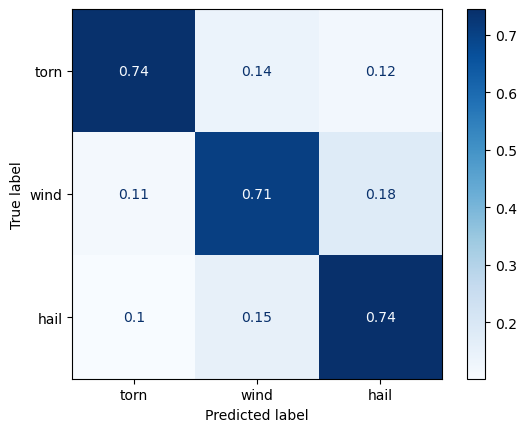

============================= LightGBM with Boruta =============================
Test Accuracy: 0.4963
Number of Features Selected: 3
Selected Feature List: ['windspeed', 'winddir', 'pressure']
Testing accuracy : 0.49633967789165445
Testing precision : [0.54166667 0.46808511 0.48275862]
Testing recall    : [0.5154185  0.49773756 0.47659574]
F1 score          : [0.5282167  0.48245614 0.47965739]
ROC AUC           : 0.677738


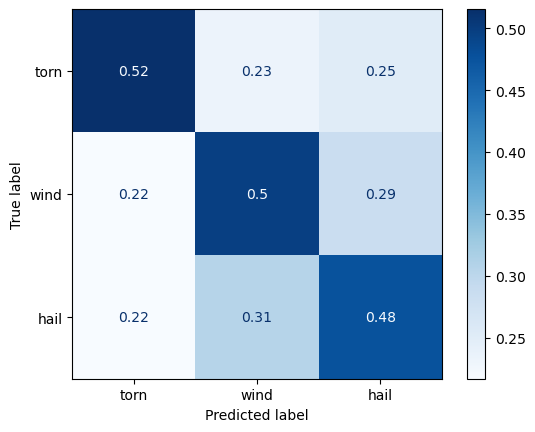

============================= LightGBM with RFE =============================
Test Accuracy: 0.7247
Number of Features Selected: 12
Selected Feature List: ['temp', 'humidity', 'dew', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'mean', 'max', 'var', 'nonzeros', 'above_threshold']
Testing accuracy : 0.7247437774524158
Testing precision : [0.78403756 0.68888889 0.70612245]
Testing recall    : [0.73568282 0.70135747 0.73617021]
F1 score          : [0.75909091 0.69506726 0.72083333]
ROC AUC           : 0.874821


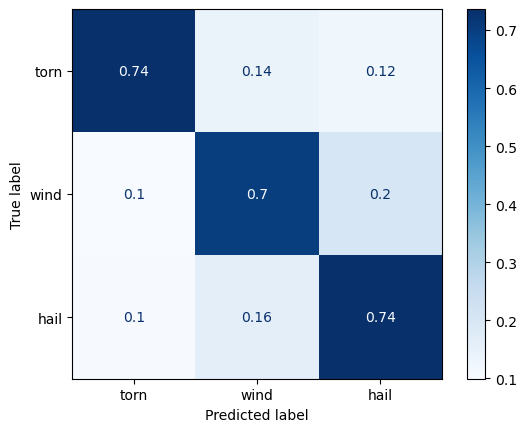

============================= LightGBM with RFA =============================
Test Accuracy: 0.6837
Number of Features Added: 7
Selected Feature List: ['humidity', 'dew', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'max']
Testing accuracy : 0.6837481698389458
Testing precision : [0.69527897 0.6635514  0.69067797]
Testing recall    : [0.71365639 0.64253394 0.69361702]
F1 score          : [0.70434783 0.65287356 0.69214437]
ROC AUC           : 0.831106


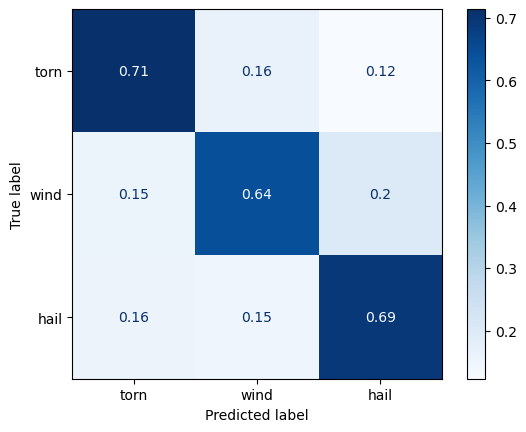

In [6]:
from sklearn.base import clone

print('============================= Original LightGBM =============================')
lgb = LGBMClassifier(n_estimators=500, verbose=-1)
lgb.fit(train_x, train_y)
test_accuracy = lgb.score(test_x, test_y)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Features Used: {train_x.shape[1]}")
print(f"Feature List: {train_x.columns.tolist()}")
evaluate(lgb, train_x, train_y, test_x, test_y)


print('============================= LightGBM with Boruta =============================')
lgb = LGBMClassifier(n_estimators=500, verbose=-1)
boruta_lgb = BoostBoruta(lgb, max_iter=20, perc=100)
boruta_lgb.fit(train_x.values, train_y)
selected_features_boruta = train_x.columns[boruta_lgb.support_].tolist()
train_x_selected = train_x[selected_features_boruta]
test_x_selected = test_x[selected_features_boruta]

# Re-train using only the selected features
lgb.fit(train_x_selected, train_y)
test_accuracy = lgb.score(test_x_selected, test_y)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Features Selected: {len(selected_features_boruta)}")
print(f"Selected Feature List: {selected_features_boruta}")
evaluate(lgb, train_x_selected, train_y, test_x_selected, test_y)

print('============================= LightGBM with RFE =============================')
lgb = LGBMClassifier(n_estimators=500, verbose=-1)
rfe_lgb = RFE(lgb, n_features_to_select=12)
rfe_lgb.fit(train_x, train_y)

# Determine the selected features
selected_features_rfe = train_x.columns[rfe_lgb.support_].tolist()
train_x_selected_rfe = train_x[selected_features_rfe]
test_x_selected_rfe = test_x[selected_features_rfe]

# Evaluate the model using only the selected features
test_accuracy = rfe_lgb.estimator_.score(test_x_selected_rfe, test_y)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Features Selected: {len(selected_features_rfe)}")
print(f"Selected Feature List: {selected_features_rfe}")

evaluate(rfe_lgb.estimator_, train_x_selected_rfe, train_y, test_x_selected_rfe, test_y)

print('============================= LightGBM with RFA =============================')
lgb = LGBMClassifier(n_estimators=500, verbose=-1)
rfa_lgb = RecursiveFeatureAddition(estimator=lgb, scoring="accuracy", cv=3)

# Assuming fit_transform returns a DataFrame with selected features
train_x_selected_rfa = rfa_lgb.fit_transform(train_x, train_y)
selected_features_rfa = train_x_selected_rfa.columns.tolist()
test_x_selected_rfa = test_x[selected_features_rfa]

# Evaluate the initial model with the selected features
initial_lgb = clone(lgb)  # Use a fresh model instance
initial_lgb.fit(train_x_selected_rfa, train_y)
test_accuracy = initial_lgb.score(test_x_selected_rfa, test_y)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Features Added: {len(selected_features_rfa)}")
print(f"Selected Feature List: {selected_features_rfa}")

evaluate(initial_lgb, train_x_selected_rfa, train_y, test_x_selected_rfa, test_y)
